In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import normalize
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, scale
import matplotlib.pyplot as plt

In [2]:
AAPL = pd.read_csv('../data/transactions/Tech/AAPL.csv')  
GOOG = pd.read_csv('../data/transactions/Tech/GOOG.csv')  
FB = pd.read_csv('../data/transactions/Tech/FB.csv')  
MSFT = pd.read_csv('../data/transactions/Tech/MSFT.csv')  
AMZN = pd.read_csv('../data/transactions/Tech/AMZN.csv') 
ALK = pd.read_csv('../data/transactions/Airline/ALK.csv')  
DAL = pd.read_csv('../data/transactions/Airline/DAL.csv')  
LUV = pd.read_csv('../data/transactions/Airline/LUV.csv')  
RYAAY = pd.read_csv('../data/transactions/Airline/RYAAY.csv')  
SAVE = pd.read_csv('../data/transactions/Airline/SAVE.csv') 
JACK = pd.read_csv('../data/transactions/Fastfood/JACK.csv')  
MCD = pd.read_csv('../data/transactions/Fastfood/MCD.csv')  
TACO = pd.read_csv('../data/transactions/Fastfood/TACO.csv')  
WEN = pd.read_csv('../data/transactions/Fastfood/WEN.csv')  
YUM = pd.read_csv('../data/transactions/Fastfood/YUM.csv') 
GS = pd.read_csv('../data/transactions/Finance/GS.csv')  
JPM = pd.read_csv('../data/transactions/Finance/JPM.csv')  
MER = pd.read_csv('../data/transactions/Finance/MER-PK.csv')  
MS = pd.read_csv('../data/transactions/Finance/MS.csv')  
WFC = pd.read_csv('../data/transactions/Finance/WFC.csv') 
COST = pd.read_csv('../data/transactions/Retailer/COST.csv')  
HD = pd.read_csv('../data/transactions/Retailer/HD.csv')  
KR = pd.read_csv('../data/transactions/Retailer/KR.csv')  
TGT = pd.read_csv('../data/transactions/Retailer/TGT.csv')  
WMT = pd.read_csv('../data/transactions/Retailer/WMT.csv') 

# pick one to train model
stockdata = JPM


In [3]:
def getStock(stock):
    date = pd.to_datetime(stock["Date"])
    stock = stock.drop(['Date'],axis=1)
    stock= stock.astype('float64')

    return scale(stock), scale(stock['Close'])


#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.
def processData(stock, input_unit,output_unit):
    data,result = getStock(stock)
    X,Y = [],[]
    for i in range(len(data)-input_unit-output_unit):
        X.append(data[i:(i+input_unit)])
        temp = [result[j+i+input_unit] for j in range(output_unit)]
        Y.append(temp)
    return np.array(X),np.array(Y)

def category(data):
    data[data>=0] = 1
    data[data<0] = -1
    return data
    
def precentage(prediction, real):
    pred = prediction -real
    pred = np.squeeze(prediction, axis=1)
    pred = category(pred)
   
    return pred
def realPrecentage(stock):
    value = pd.Series(stock['Close']-stock['Close'].shift(1), index=stock.index) 
    value = value.bfill() 
    value = np.array(value) 
    val = category(value)
   
    return val
def compare(pred, val):
    t = len(pred)
    countTrue = 0
    for i in range(t):
        if pred[i] == val[i]:
            countTrue +=1
    return countTrue/t




In [9]:
time_size = 5
train_precentage = 0.75

X,y = processData(stockdata,time_size,1)
train_size = int(X.shape[0]*0.80)
X_train,X_test = X[:int(X.shape[0]*train_precentage)],X[int(X.shape[0]*train_precentage):]
y_train,y_test = y[:int(y.shape[0]*train_precentage)],y[int(y.shape[0]*train_precentage):]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(939, 5, 6)
(939, 1)
(313, 5, 6)
(313, 1)


In [10]:
model = tf.keras.models.load_model('LSTM')
if model == None:
    print('train from begining')
    model = Sequential() # most common
    model.add(LSTM(64, input_shape = (time_size,6), return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(LSTM(32, input_shape = (time_size,6), return_sequences=False)) 
    model.add(Dropout(0.2))
    model.add(Dense(16, kernel_initializer='uniform', activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(optimizer='adam', loss='mean_squared_error') 
callback = EarlyStopping(monitor='val_loss', patience=10,verbose=1,mode='auto')
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[callback])

Train on 939 samples, validate on 313 samples
Epoch 1/300
939/939 [==============================] - 2s 2ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 2/300
939/939 [==============================] - 0s 410us/step - loss: 0.0085 - val_loss: 0.0117
Epoch 3/300
939/939 [==============================] - 0s 395us/step - loss: 0.0085 - val_loss: 0.0070
Epoch 4/300
939/939 [==============================] - 0s 409us/step - loss: 0.0080 - val_loss: 0.0099
Epoch 5/300
939/939 [==============================] - 0s 469us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 6/300
939/939 [==============================] - 0s 453us/step - loss: 0.0085 - val_loss: 0.0162
Epoch 7/300
939/939 [==============================] - 0s 445us/step - loss: 0.0069 - val_loss: 0.0060
Epoch 8/300
939/939 [==============================] - 0s 431us/step - loss: 0.0073 - val_loss: 0.0147
Epoch 9/300
939/939 [==============================] - 0s 419us/step - loss: 0.0067 - val_loss: 0.0060
Epoch 10/300
939/939 [=======

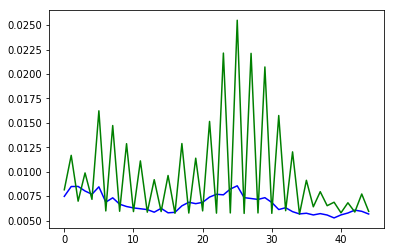

In [11]:
plt.plot(history.history['loss'],color="blue")
plt.plot(history.history['val_loss'],color="green")
plt.show()

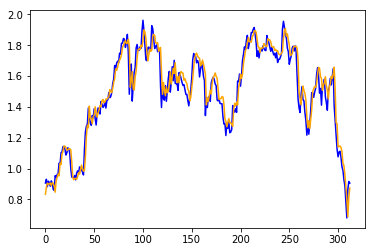

0.4904153354632588


In [12]:
prediction = model.predict(X_test)

real = y_test
plt.plot(real,color="blue")
plt.plot(prediction,color="orange")
plt.show()

inputg,outputg = processData(stockdata,time_size,1)
prediction = model.predict(inputg)
pred = precentage(prediction, outputg)
val = realPrecentage(stockdata)
print(compare(pred, val))
#print(prediction)
#print(real)

In [13]:
tf.keras.models.save_model(model,'LSTM')
